# Problem Set 3

### Before You Start

Make sure the following libraries load correctly (hit Ctrl-Enter). Note that while you are loading several powerful libraries, including machine learning libraries, the goal of this problem set is to implement several algorithms from scratch. In particular, you should *not* be using any built-in libraries for nearest neighbors, distance metrics, or cross-validation -- your mission is to write those algorithms in Python! Part 1 will be relatively easy; Part 2 will take more time.

In [1]:
import IPython
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib
import sklearn
import seaborn as sns

In [2]:
%matplotlib inline  
%config Completer.use_jedi = False
import matplotlib.pyplot as plt  
from heapq import * 
import random
pd.options.mode.chained_assignment = None

---

## Introduction to the assignment

For this assignment, you will be using the [Boston Housing Prices Data Set](http://www.kellogg.northwestern.edu/faculty/weber/emp/_session_3/boston.htm).  Please read about the dataset carefully before continuing.  Use the following commands to load the dataset:

*NOTE - This dataset is similar to the one you used in PS1; we are just using a different method to load it this time. The column names and their order will remain the same for this dataset as was in PS1.*

In [3]:
# load Boston housing data set
data = np.loadtxt('data.txt')
target = np.loadtxt('target.txt')
target = target.reshape(-1, 1)
full_data = np.append(data,target, axis=1)
full_data = np.append(full_data, np.zeros(len(data)).reshape(-1,1), axis=1)
df = pd.DataFrame(full_data)
df.columns = ['CRIM','ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD' ,'TAX' ,'PTRATIO'
 ,'B', 'LSTAT', 'MEDV', 'predictions']


In [4]:
features_df = df.drop(['MEDV'],axis=1)
target_df = df['MEDV']

---

## Part 1: Experimental Setup

The goal of the next few sections is to design an experiment to predict the median home value for an instance in the data.
Before beginning the "real" work, refamiliarize yourself with the dataset.

### 1.1 Begin by writing a function to compute the Root Mean Squared Error for a list of numbers

You can find the sqrt function in the Numpy package. Furthermore the details of RMSE can be found on [Wikipedia](http://en.wikipedia.org/wiki/Root-mean-square_deviation). Do not use a built-in function  to compute RMSE, other than numpy functions like `sqrt` and if needed, `sum` or other relevant ones.

In [5]:
"""
Function
--------
compute_rmse

Given two arrays, one of actual values and one of predicted values,
compute the Roote Mean Squared Error

Parameters
----------
predictions : array
    Array of numerical values corresponding to predictions for each of the N observations

yvalues : array
    Array of numerical values corresponding to the actual values for each of the N observations

Returns
-------
rmse : int
    Root Mean Squared Error of the prediction

Example
-------
>>> print(compute_rmse((2,2,3),(0,2,6)))
2.08
"""
def compute_rmse(predictions, yvalues):
    rmse = np.sqrt(np.mean((np.array(yvalues) - np.array(predictions))**2))
    return rmse

In [6]:
compute_rmse((2,2,3),(0,2,6))

2.0816659994661326

### 1.2 Divide your data into training and testing datasets

Randomly select 75% of the data and put this in a training dataset (call this "bdata_train"), and place the remaining 25% in a testing dataset (call this "bdata_test"). Do not use built-in functions.

To perform any randomized operation, only use functions in the *numpy library (np.random)*. Do not use other packages for random functions.

In [7]:
data.shape, target.shape

((506, 13), (506, 1))

In [8]:
# leave the following line untouched, it will help ensure that your "random" split is the same "random" split used by the rest of the class
np.random.seed(seed=13579)

In [9]:
nrow = len(data)
nrow_in_train = int(nrow * 0.75)
nrow_in_test = nrow - nrow_in_train
exclude = np.random.choice(nrow, nrow_in_test, replace=False)

In [10]:
mask = np.ones(nrow, bool)
mask[exclude] = False
train = df[mask]
test = df[~mask]

### 1.3 Use a very bad baseline for prediction, and compute RMSE

Let's start by creating a very bad baseline model that predicts median home values as the averages of `MEDV` based on adjacency to Charles River. 

Specifically, create a model that predicts, for every observation X_i, the median home value as the average of the median home values of all houses in the **training set** that have the same adjacency value as the observation.

For example - For an input observation where `CHAS==1`, the model should predict the `MEDV` as the mean of all `MEDV` values in the training set that also have `CHAS==1`.



Once the model is built, do the following:

1. Compute the RMSE of the training set.
2. Now compute the RMSE of the test data set (but use the model you trained on the training set!).
3. How does RMSE compare for training vs. testing datasets? Is this what you expected, and why?
4. Create a scatter plot that shows the true value of each instance on the x-axis and the predicted value of each instance on the y-axis. Color the training instances in blue and the test instances in red. Make sure to label your axes appropriately, and add a legend to your figure to make clear which dots are which.
5. Add code to your function to measure the running time of your algorithm. How long does it take to compute the predicted values for the test data?


*NOTE - Be careful while dealing with floats and integers. Additionally, the `groupby` operation might come handy here.*

In [11]:
train.groupby(['CHAS']).mean()['MEDV']

CHAS
0.0    22.228205
1.0    30.596429
Name: MEDV, dtype: float64

In [12]:
#calculate the average for each group
y_hat_0 = train.groupby(['CHAS']).mean()['MEDV'][0]
y_hat_1 = train.groupby(['CHAS']).mean()['MEDV'][1]

1. Compute the RMSE of the training set.

In [13]:
#1
mask = train['CHAS'] == 0
train.loc[mask,'predictions'] = y_hat_0
train.loc[~mask,'predictions'] = y_hat_1

compute_rmse(train['predictions'], train['MEDV'])

9.125174724475736

2. Now compute the RMSE of the test data set (but use the model you trained on the training set!).

In [14]:
#2
mask = test['CHAS'] == 0
test.loc[mask,'predictions'] = y_hat_0
test.loc[~mask,'predictions'] = y_hat_1

compute_rmse(test['predictions'], test['MEDV'])

8.880924989704944

3. How does RMSE compare for training vs. testing datasets? Is this what you expected, and why?
 * They are about the same. Yes, because we are using the averages as predictions. Sample averages in training and testing data set are about the same.

4. Create a scatter plot that shows the true value of each instance on the x-axis and the predicted value of each instance on the y-axis. Color the training instances in blue and the test instances in red. Make sure to label your axes appropriately, and add a legend to your figure to make clear which dots are which.

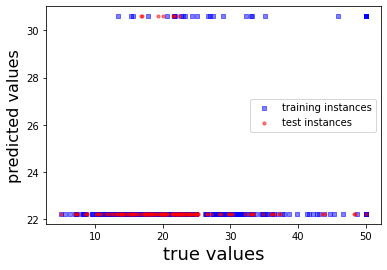

In [15]:
fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter(train['MEDV'], train['predictions'], s=10, c='b', marker="s", alpha=0.5,label='training instances')
ax1.scatter(test['MEDV'],test['predictions'], s=10, c='r',alpha=0.5, marker="o", label='test instances')
plt.legend(loc='center right');
plt.xlabel('true values', fontsize=18)
plt.ylabel('predicted values', fontsize=16)
plt.show()


5. Add code to your function to measure the running time of your algorithm. How long does it take to compute the predicted values for the test data?

In [16]:
import time
def compute_rmse(predictions, yvalues):
    rmse = np.sqrt(np.mean((np.array(yvalues) - np.array(predictions))**2))
    return rmse

In [17]:
start = time.time()
rmse = compute_rmse(test['predictions'], test['MEDV'])
end = time.time()
print(f"time takes to compute rmse is: {round(end - start)}s")
print(f"rmse is {rmse}")

time takes to compute rmse is: 0s
rmse is 8.880924989704944


---

## Part 2: Nearest Neighbors


### 2.1 Nearest Neighbors: Distance function
Let's try and build a machine learning algorithm to beat the "Average Value" baseline that you computed above.  Soon you will implement the Nearest Neighbor algorithm, but first you need to create a distance metric to measure the distance (and similarity) between two instances.  Write a generic function to compute the L-Norm distance (called the [*p*-norm][1] distance on Wikipedia). Verify that your function works by computing the Euclidean distance between the points (1,2) and (1,8), and then compute the Manhattan distance between (4,4) and (12,10).

[1]: https://en.wikipedia.org/wiki/Norm_(mathematics)#p-norm

In [18]:
"""
Function
--------
distance

Given two instances and a value for L, return the L-Norm distance between them

Parameters
----------
x1, x2 : array
    Array of numerical values corresponding to predictions for each of the N observations

L: int
    Value of L to use in computing distances

Returns
-------
dist : int
    The L-norm distance between instances

Example
-------
>>> print(distance((1,2),(1,8),2))
6

"""
def distance(x1, x2, L):
    x1 = np.array(x1)
    x2 = np.array(x2)
    dist = (np.sum(abs(x1-x2)**L))**(1/L)
    return dist

In [19]:
distance((1,2),(1,8),2)

6.0

In [20]:
distance((4,4),(12,10),1)

14.0

### 2.2 Basic Nearest Neighbor algorithm

Your next task is to implement a basic nearest neighbor algorithm from scratch.  Your simple model will use three input features (`CRIM, RM and ZN`) and a single output (`MEDV`).  In other words, you are modelling the relationship between median home value and crime rates, house size and the proportion of residential land zoned for lots.

Use your training data (bdata_train) to "fit" your model, although as you know, with Nearest Neighbors there is no real training, you just need to keep your training data in memory.  Write a function that predicts the median home value using the nearest neighbor algorithm we discussed in class.  Since this is a small dataset, you can simply compare your test instance to every instance in the training set, and return the `MEDV` value of the closest training instance.  Have your function take L as an input, where L is passed to the distance function. Use L=2 for all questions henceforth unless explicitly stated otherwise.

Make sure to do the following - 
1. Fill in the function specification below
2. Use your algorithm to predict the median home value of every instance in the test set. Report the RMSE ("test RMSE")
3. Use your algorithm to predict the median home value of every instance in the training set and report the training RMSE.
4. Create a scatter plot that shows the true value of each instance on the x-axis and the predicted value of each instance on the y-axis. Color the training instances in blue and the test instances in red. 
5. Report an estimate of the total time taken by your code to predict the nearest neighbors for all the values in the test data set.
6. How does the performance (test RMSE and total runtime) of your nearest neighbors algorithm compare to the baseline in part 1.3?

In [21]:
"""
Function
--------
Nearest Neighbors

Implementation of nearest neighbors algorithm.

Parameters
----------
x_train: array
    Array of numerical feature values for training the model.
y_train: array
    Array of numerical output values for training the model.
x_test: array
    Array of numerical feature values for testing the model.
y_test: array
    Array of numerical output values for testing the model.
L: int
    Order of L-norm function used for calculating distance.

Returns
-------
rmse : int
    Value of the RMSE from data.
"""

def nneighbor(x_train,y_train,x_test,y_test, L, features, display_time=True):
    start_time = time.time()
    preds = np.zeros(len(x_test))
    for i in range(len(preds)):
        dists = 10**10
        xi = np.array(x_test.iloc[i,features])
        for j in range(len(x_train)):
            xj = np.array(x_train.iloc[j,features])
            new_dist = distance(xi, xj, L)
            if new_dist < dists:
                dists = new_dist
                preds[i] = y_train.iloc[j]
    
    rmse = compute_rmse(preds, y_test)
    if display_time:
        print("Time taken: {:.2f} seconds".format(time.time() - start_time))
    return rmse , preds


2. Use your algorithm to predict the median home value of every instance in the test set. Report the RMSE ("test RMSE")

In [22]:
test_rmse, test_preds = nneighbor(train,train['MEDV'],test,test['MEDV'], 2, [0,1,5])
print(f"the test rmse is {test_rmse}")

Time taken: 9.30 seconds
the test rmse is 7.570570870620433


3. Use your algorithm to predict the median home value of every instance in the training set and report the training RMSE.
 * In 1-nearest neighbor the training error is 0 because the closest point to each instance is itself.

In [23]:
#3
def nneighbor2(x_train,y_train,x_test,y_test, L):
    start_time = time.time()
    preds = y_train
    rmse = compute_rmse(preds, y_train)
    print("Time taken: {:.2f} seconds".format(time.time() - start_time))
    return rmse, preds

train_rmse, train_preds = nneighbor2(train,train['MEDV'],test,test['MEDV'], 2)
print(f"the train rmse is {train_rmse}")

Time taken: 0.00 seconds
the train rmse is 0.0


4. Create a scatter plot that shows the true value of each instance on the x-axis and the predicted value of each instance on the y-axis. Color the training instances in blue and the test instances in red. 

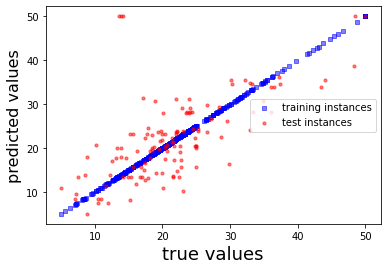

In [24]:
fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter(train['MEDV'], train_preds, s=10, c='b', marker="s", alpha=0.5,label='training instances')
ax1.scatter(test['MEDV'],test_preds, s=10, c='r',alpha=0.5, marker="o", label='test instances')
plt.legend(loc='center right');
plt.xlabel('true values', fontsize=18)
plt.ylabel('predicted values', fontsize=16)
plt.show()

5. Report an estimate of the total time taken by your code to predict the nearest neighbors for all the values in the test data set.

In [25]:
test_rmse, test_preds = nneighbor(train,train['MEDV'],test,test['MEDV'], 2, list(range(14)))
print(f"the test rmse is {test_rmse}")

Time taken: 9.55 seconds
the test rmse is 4.560934770883264


6. How does the performance (test RMSE and total runtime) of your nearest neighbors algorithm compare to the baseline in part 1.3?
 * RMSE is lower and runtime is slower than 1.3 baseline method

### 2.3 Results and Normalization

If you were being astute, you would have noticed that we never normalized our features -- a big no-no with Nearest Neighbor algorithms.  Write a generic normalization function that takes as input an array of values for a given feature, and returns the standardized array (subtract the mean and divide by the standard deviation).

Re-run the Nearest Neighbor algorithm on the normalized dataset (still just using `CRIM, RM and ZN` as input), and compare the RMSE from this method with your previous RMSE evaluations. What do you observe?

*NOTE*: To normalize properly, you should compute the mean and standard deviation on the training set, and use the same values to normalize both the training and the testing dataset.

*NOTE 2*: In this case, the normalization may or may not reduce the RMSE; don't get confused if you find that to be the case.

In [99]:
"""
Function
--------
Normalize data

Normalize all of the features in a data frame.

Parameters
----------
raw_data: array
    Array of numerical values to normalize.

Returns
-------
normalized_data : array
    The array with normalized values for all features
"""


def normalize(raw_data, mean, std):
    normalized_data=(raw_data - mean)/std
    return normalized_data

normalized_train = normalize(train, train.mean(),  train.std())
normalized_test = normalize(test, train.mean(), train.std())

In [100]:
test_rmse, test_preds = nneighbor(normalized_train, train['MEDV'], normalized_test, test['MEDV'], L=2, features=[0,1,5])
print(f"the test rmse is {test_rmse}")

Time taken: 9.59 seconds
the test rmse is 8.95689150943624


the test rmse has increased from 7.570570870620433 to 8.95689150943624

### 2.4 Optimization

A lot of the decisions we've made so far have been arbitrary.  Try to increase the performance of your nearest neighbor algorithm by adding features that you think might be relevant, and by using different values of L in the distance function.  Try a model that uses a different set of 2 features, then try at least one model that uses more than 4 features, then try using a different value of L.  If you're having fun, try a few different combinations of features and L! Use the test set to report the RMSE values.

What combination of features and distance function provide the lowest RMSE on the test set?  Do your decisions affect the running time of the algorithm?

*NOTE:* For this and all subsequent questions, you should use normalized features. 

In [29]:
#model 1: include 'TAX' and 'PTRATIO'
test_rmse, test_preds = nneighbor(normalized_train,train['MEDV'],normalized_test,test['MEDV'], 2, [9, 10])
print(f"the test rmse is {test_rmse}")

Time taken: 9.50 seconds
the test rmse is 7.124047111305097


In [30]:
#model 2: include 'TAX', 'PTRATIO', 'RM', 'INDUS' and 'LSTAT'
test_rmse, test_preds = nneighbor(normalized_train,train['MEDV'],normalized_test,test['MEDV'], 2, [2, 5, 9, 10, 12])
print(f"the test rmse is {test_rmse}")

Time taken: 9.79 seconds
the test rmse is 4.5798342644427406


In [31]:
#model 3: include 'TAX', 'PTRATIO', 'RM', 'INDUS' and 'LSTAT' and L=1
test_rmse, test_preds = nneighbor(normalized_train,train['MEDV'],normalized_test,test['MEDV'], 1, [2, 5, 9, 10, 12])
print(f"the test rmse is {test_rmse}")

Time taken: 9.62 seconds
the test rmse is 4.693914639793665


* model 2 gives the lowest RMSE
* adding more features will slow down the runtime

### 2.5 Cross-Validation

The more you tinkered with your features and distance function, the higher the risk that you overfit your training data.  One solution to this sort of overfitting is to use cross-validation (see K-fold [cross-validation][1].  Here you must implement a simple k-fold cross-validation algorithm yourself.  The function you write here will be used several more times in this problem set, so do your best to write efficient code! (Note that the sklearn package has a built-in [K-fold][2] iterator -- you should *not* be invoking that or any related algorithms in this section of the problem set.)

Use 50-fold cross-validation and report the average RMSE for Nearest Neighbors using Euclidean distance with `CRIM,RM and ZN` input features, as well as the total running time for the full run of 50 folds.  In other words, randomly divide your training dataset (created in 1.2) into 50 equally-sized samples.

For each of the 50 iterations (the "folds"), use 49 samples as "training data" (even though there is no training in k-NN!), and the remaining 1 sample for validation.  Compute the RMSE of that particular validation set, then move on to the next iteration.  

 - Report the average cross-validated RMSE across the 50 iterations. What do you observe?
 
 - Create a histogram of the RMSEs for the folds (there should be 50 of these). Additionally, use a horizontal line to mark the average cross-validated RMSE.


[1]: http://en.wikipedia.org/wiki/Cross-validation_(statistics)
[2]: http://scikit-learn.org/stable/modules/cross_validation.html#cross-validation



NOTE: To perform any randomized operation, only use functions in the *numpy library (np.random)*. Do not use other packages for random functions.

HINT: Running 50-fold cross validation might be time-consuming. Try starting with 5 folds.

In [60]:
np.random.seed(1)

In [84]:
def CV(df, num_folds, nrow):
    indices = list(range(nrow))
    np.random.shuffle(indices)
    folds = np.array_split(indices, num_folds)
    k_folds_rmse = np.zeros(num_folds)
    for i in range(len(folds)):
        test_indices = folds[i]
        train_indices = np.concatenate(np.delete(folds, i)).ravel()
        train_cv = df.iloc[train_indices]
        test_cv = df.iloc[test_indices]
        normalized_train = normalize(train_cv, train_cv.mean(),  train_cv.std())
        normalized_test = normalize(test_cv, train_cv.mean(), train_cv.std())
        test_rmse, test_preds = nneighbor(normalized_train,train_cv['MEDV'],normalized_test,test_cv['MEDV'], 2, [0,1,5], display_time=False)
        k_folds_rmse[i] = test_rmse
    return k_folds_rmse

In [85]:
k_folds_rmse = CV(train, num_folds=50, nrow=len(train))

/usr/local/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [86]:
k_folds_rmse

array([ 5.75423757,  6.05794932,  5.8850446 ,  3.91726946,  4.96361763,
        3.94414122,  4.10304765,  5.22446169, 13.64766464,  5.6781379 ,
        7.21266248,  6.92603783,  4.0931345 ,  4.37449997,  6.57181482,
        3.28842668, 14.06711591, 15.27616608,  7.14317856,  5.06717377,
        4.59075157,  6.91483912,  9.4546946 ,  4.10076212, 13.00134608,
        5.60903289,  5.26569084, 13.93727018,  8.16876674,  5.67123066,
       11.72719672,  4.47724405,  7.64852927,  5.78174467,  6.01723714,
        6.35924524,  7.3420511 ,  2.00214171,  3.49305433,  5.32634959,
        4.44923749, 14.51142407,  2.62161346,  5.41466263,  8.52349693,
        4.72772975,  7.16738645,  3.93282886,  2.94763828, 12.34284061])

Report the average cross-validated RMSE across the 50 iterations. What do you observe?

In [87]:
np.mean(k_folds_rmse)

6.73447638883018

RMSE calculated when use CV is smaller than not use CV

Create a histogram of the RMSEs for the folds (there should be 50 of these). Additionally, use a horizontal line to mark the average cross-validated RMSE.

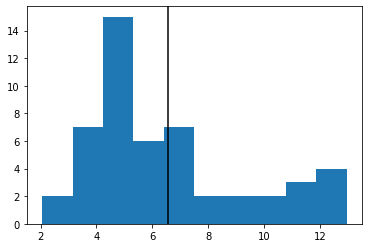

In [38]:
plt.hist(k_folds_rmse)
plt.axvline(np.mean(k_folds_rmse), color='k')
plt.show()

### 2.6 K-Nearest Neighbors Algorithm

Implement the K-Nearest Neighbors algorithm.  Use 10-fold cross validation and L2 normalization, and the same features as in 2.5. Report the RMSE for K=4 and the running time of the algorithm. What do you observe?

In [89]:
"""
Function
--------
K-Nearest Neighbors

Implementation of nearest neighbors algorithm.

Parameters
----------
x_train: array
    Array of numerical feature values for training the model.
y_train: array
    Array of numerical output values for training the model.
x_test: array
    Array of numerical feature values for testing the model.
y_test: array
    Array of numerical output values for testing the model.
L: int
    Order of L-norm function used for calculating distance.
K: int
    Neighbors to include in algorithm
    
Returns
-------
rmse : int
    Value of the RMSE from data.
"""

def knn(x_train,y_train,x_test,y_test, L, K, features, display_time=True):
    start_time = time.time()
    preds = np.zeros(len(x_test))
    for i in range(len(preds)):
        dists = []
        xi = np.array(x_test.iloc[i,features])
        for j in range(len(x_train)):
            xj = np.array(x_train.iloc[j,features])
            new_dist = distance(xi, xj, L)
            heappush(dists, (new_dist, y_train.iloc[j]))
       
        top_k_items = np.array(nsmallest(K, dists))
        preds[i] = np.mean(top_k_items[:,1])
    rmse = compute_rmse(preds, y_test)
    if display_time:
        print("Time taken: {:.2f} seconds".format(time.time() - start_time))
    return rmse, preds

def CV2(df, num_folds, nrow, k, features):
    indices = list(range(nrow))
    np.random.shuffle(indices)
    folds = np.array_split(indices, num_folds)
    k_folds_rmse = np.zeros(num_folds)
    for i in range(len(folds)):
        test_indices = folds[i]
        train_indices = np.concatenate(np.delete(folds, i)).ravel()
        train_cv = df.iloc[train_indices]
        test_cv = df.iloc[test_indices]
        normalized_train = normalize(train_cv, train_cv.mean(),  train_cv.std())
        normalized_test = normalize(test_cv, train_cv.mean(), train_cv.std())
        test_rmse, test_preds = knn(normalized_train,train_cv['MEDV'],normalized_test,test_cv['MEDV'],
                                    L=2,K=k,features= features, display_time=False)
        k_folds_rmse[i] = test_rmse
    return k_folds_rmse

In [90]:
k_folds_rmse = CV2(train, num_folds=10, nrow=len(train), k=4, features=[0,1,5])

In [91]:
np.mean(k_folds_rmse)

6.144938334034544

### 2.7 Using cross validation to find K

Compute the cross-validated RMSE for values of K between 1 and 25 using 10-fold cross-validation and L2 normalization.  Use the following features in your model: `CRIM, ZN, RM, AGE, DIS, TAX`.  Create a graph that shows how cross-validated RMSE changes as K increases from 1 to 25.  Label your axes, and summarize what you see.  What do you think is a reasonable choice of K for this model?

Finally, report the test RMSE using the value of K that minimized the cross-validated RMSE. (Continue to use L2 normalization and the same set of features). How does the test RMSE compare to the cross-validated RMSE, and is this what you expected? How does the test RMSE compare to the test RMSE from 2.4, and is this what you expected?

In [92]:
average_rmse = np.zeros(25)
for i in range(25):
    start = time.time()
    k_folds_rmse = CV2(train, num_folds=10, nrow=len(train), k=i+1, features=[0,1,5,6,7,9])
    average_rmse[i]=np.mean(k_folds_rmse)
    end = time.time()
    print(f"k={i+1}, time = {end - start}]")

k=1, time = 27.04152488708496]
k=2, time = 26.348567962646484]
k=3, time = 26.369216918945312]
k=4, time = 26.210892915725708]
k=5, time = 26.175636053085327]
k=6, time = 26.088287115097046]
k=7, time = 26.270797967910767]
k=8, time = 26.025145769119263]
k=9, time = 25.954923152923584]
k=10, time = 27.031147956848145]
k=11, time = 27.32562494277954]
k=12, time = 26.856565952301025]
k=13, time = 27.3560209274292]
k=14, time = 27.269285202026367]
k=15, time = 26.938745975494385]
k=16, time = 28.92229199409485]
k=17, time = 27.05611300468445]
k=18, time = 26.791062831878662]
k=19, time = 26.759788990020752]
k=20, time = 26.982183933258057]
k=21, time = 26.62067413330078]
k=22, time = 27.391767978668213]
k=23, time = 28.173285007476807]
k=24, time = 28.02463412284851]
k=25, time = 26.845809936523438]


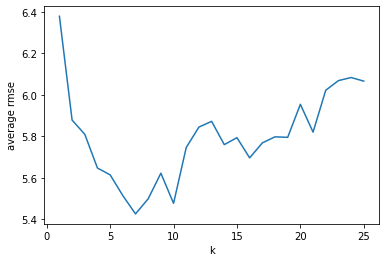

when k = 6, the average cross-validated RMSE is the smallest


In [98]:
x = np.arange(1,26)
y = average_rmse
plt.plot(x, y)
plt.xlabel("k")
plt.ylabel("average rmse")
plt.show()
print(f"when k = {np.argmin(average_rmse)}, the average cross-validated RMSE is the smallest")

In [101]:
test_rmse, test_preds = knn(normalized_train,train['MEDV'],normalized_test,test['MEDV'],
                                    L=2,K=6,features= [0,1,5,6,7,9], display_time=False)

In [102]:
test_rmse

3.641033942643019

in 2.4, the smallest test rmse is 4.5798342644427406  
in 2.7, k=6, the smallest test rmse is 3.641033942643019  
It is what I expected as optimal k is choosen by cross validaiton. This model generalizes better than naive k=1 in 2.4

### Extra-Credit: Forward selection

Thus far the choice of predictor variables has been rather arbitrary. For extra credit, implement a basic [forward selection](https://see.stanford.edu/materials/aimlcs229/cs229-notes5.pdf) algorithm to progressively include features that decrease the cross-validated RMSE of the model. Note that the optimal value of K may be different for each model, so you may want to use cross-validation to choose K each time (but it is also fine if you fix K at the optimal value from 2.7).  Create a graph that shows RMSE as a function of the number of features in the model. Label each point on the x-axis with the name of the feature that is added at that step in the forward selection algorithm. *(For instance, if the optimal single-feature model has CRIM with RMSE = 10, and the optimal two-feature model has CRIM+ZN with RMSE=9, the first x-axis label will say CRIM and the second x-axis lable with say ZN)*

### The runtime for full data set is too slow. I choose to use a subset of the original data to show my code works.

In [171]:
temp_train = train.iloc[:100,]
temp_test = test.iloc[:10,]

# temp_train = train.copy()
# temp_test = test.copy()

temp_normalized_train = normalize(temp_train, temp_train.mean(),  temp_train.std())
temp_normalized_test = normalize(temp_test, temp_train.mean(), temp_train.std())

In [172]:
total_num_features = 13
num_features_selected = 1
track_feature_selected = []
track_rmse = []
all_feature_names = temp_test.drop(['MEDV', 'predictions'], axis=1).columns
feature_selected =[]

while num_features_selected != total_num_features:
    start = time.time()

    curr_feature_names = temp_train.columns
    candidate_feature_length = total_num_features - num_features_selected
    each_feature_rmse = np.zeros(total_num_features)
    
    for i in range(total_num_features):
        if i not in feature_selected:
            test_rmse, test_preds = knn(temp_normalized_train,temp_train['MEDV'],temp_normalized_test,temp_test['MEDV'],
                                            L=2, K=6, features = feature_selected + [i], display_time=False)
            each_feature_rmse[i] = round(test_rmse, 3)
        else:
            each_feature_rmse[i] = 100
    
    curr_feature_selected = np.argmin(each_feature_rmse)
    feature_selected.append(curr_feature_selected)    
    num_features_selected += 1
    track_feature_selected.append(all_feature_names[curr_feature_selected])
    track_rmse.append(np.min(each_feature_rmse))
    
    print("current feature selected is ",curr_feature_selected, "test rmse is", np.min(each_feature_rmse))
    print(track_feature_selected)
    print(f"time takes for each selection: {round(time.time() - start, 2)} s")
    print()

current feature selected is  5 test rmse is 3.222
['RM']
time takes for each selection: 2.9 s

current feature selected is  6 test rmse is 2.456
['RM', 'AGE']
time takes for each selection: 2.75 s

current feature selected is  8 test rmse is 1.629
['RM', 'AGE', 'RAD']
time takes for each selection: 2.47 s

current feature selected is  12 test rmse is 1.663
['RM', 'AGE', 'RAD', 'LSTAT']
time takes for each selection: 2.36 s

current feature selected is  2 test rmse is 1.676
['RM', 'AGE', 'RAD', 'LSTAT', 'INDUS']
time takes for each selection: 2.02 s

current feature selected is  10 test rmse is 1.501
['RM', 'AGE', 'RAD', 'LSTAT', 'INDUS', 'PTRATIO']
time takes for each selection: 1.8 s

current feature selected is  11 test rmse is 1.49
['RM', 'AGE', 'RAD', 'LSTAT', 'INDUS', 'PTRATIO', 'B']
time takes for each selection: 1.58 s

current feature selected is  9 test rmse is 1.459
['RM', 'AGE', 'RAD', 'LSTAT', 'INDUS', 'PTRATIO', 'B', 'TAX']
time takes for each selection: 1.33 s

current fe

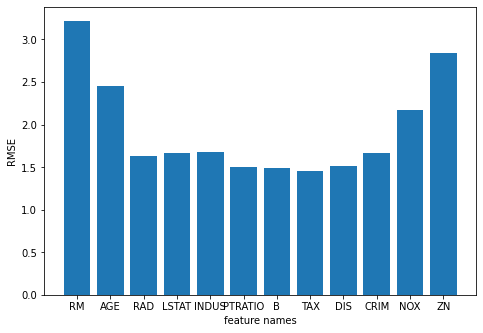

In [173]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
langs = track_feature_selected
students = track_rmse
ax.bar(langs,students)
ax.set_xlabel("feature names")
ax.set_ylabel("RMSE")
plt.show()